In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')

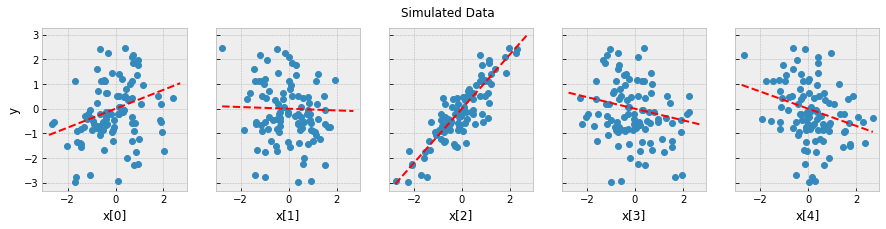

In [8]:
np.random.seed(0)

ndims = 5
ndata = 100
X = np.random.randn(ndata, ndims)
w_ = np.random.randn(ndims)

noise_ = 0.1 * np.random.randn(ndata)
y_obs = X.dot(w_) + noise_


fig, axes = plt.subplots(sharey=True, ncols=ndims, figsize=(15, 3))

t = np.linspace(X.min(), X.max())
for idx, (ax, x) in enumerate(zip(axes.ravel(), X.T)):
    ax.plot(x, y_obs, 'o');
    ax.plot(t, w_[idx] * t, 'r--')
    ax.set_xlabel(f'x[{idx}]')
axes[0].set_ylabel('y')
fig.suptitle('Simulated Data');

## The Model

We have generated a linear regression dataset with 5 dimensions and 100 datapoints. 

In each library, we will define the joint probability distribution

$$
p(\mathbf{w}) \sim \mathcal{N}(\mathbf{0}, I_5)\\
p(\mathbf{y} | X, \mathbf{w}) \sim \mathcal{N}(X\mathbf{w}, 0.1I_{100}),
$$
where $I_5$ is a $5 \times 5$ identity matrix, and $I_{100}$ a $100 \times 100$ identity.

We then provide code to sample 1,000 draws from the posterior distribution: 

$$
p(\mathbf{w} | X, \mathbf{y}) \propto p(\mathbf{y} | X, \mathbf{w}) p(\mathbf{w})
$$

Note that in this case we can just do the math, and the actual posterior is

$$
p(\mathbf{w} | X, \mathbf{y}) = \mathcal{N}((X^TX + I_5)^{-1}X^Ty, (X^TX + I_5)^{-1})
$$



# Hamiltonian Mxnet

In [87]:
import sys
sys.path.append("../") 

In [96]:
import mxnet as mx
from mxnet import nd, autograd, gluon

model_ctx=mx.cpu()
par={'weights':nd.random_normal(shape=ndims,ctx=model_ctx),'bias':nd.random_normal(shape=1,ctx=model_ctx)}
hyper={'alpha':nd.array(10.0, ctx=model_ctx),'scale':1}

In [97]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.linear)
importlib.reload(hamiltonian.inference.hmc)

<module 'hamiltonian.inference.hmc' from '../hamiltonian/inference/hmc.py'>

In [98]:
from hamiltonian.inference.hmc import hmc
from hamiltonian.models.linear import linear

model=linear(hyper,ctx=model_ctx)
inference=hmc(model,par,step_size=0.1,ctx=model_ctx)

In [99]:
X_train=nd.array(X,ctx=model_ctx)
y_train=nd.array(y_obs,ctx=model_ctx)
posterior_samples,loss=inference.fit(epochs=100,burn_in=30,
                           path_length=1.0,X_train=X_train,y_train=y_train)

100%|██████████| 100/100 [00:01<00:00, 74.00it/s]


In [100]:
posterior_samples_numpy=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples[var]]),0)
        })

In [104]:
posterior_samples_numpy['bias']

array([[[-2.7555978 ],
        [-0.9474352 ],
        [-0.9474352 ],
        [-0.9474352 ],
        [-0.9474352 ],
        [-2.8870468 ],
        [-2.938219  ],
        [-2.9464574 ],
        [-2.9464574 ],
        [-2.9464574 ],
        [-0.96231747],
        [-0.96231747],
        [-0.96231747],
        [-1.176805  ],
        [ 0.14438595],
        [ 0.14438595],
        [ 0.14438595],
        [ 0.14438595],
        [ 0.14438595],
        [ 0.14438595],
        [ 0.14438595],
        [ 0.14438595],
        [-0.9771517 ],
        [-0.09753604],
        [-0.09753604],
        [-0.09753604],
        [-0.09753604],
        [-0.09753604],
        [-0.09753604],
        [-0.09753604],
        [-0.09753604],
        [-0.5509259 ],
        [-0.5509259 ],
        [ 0.80591166],
        [ 0.80591166],
        [ 0.80591166],
        [ 0.58355665],
        [ 0.58355665],
        [ 0.58355665],
        [ 1.6703224 ],
        [ 1.6703224 ],
        [ 1.6703224 ],
        [ 1.6703224 ],
        [ 1